# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
print(X_train_feats.shape)

(49000, 155)


In [32]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [3e-8, 4e-8, 5e-8]
regularization_strengths = [5e5, 10e5, 15e5, 10e5, 25e5]

for rate in learning_rates:
    for strength in regularization_strengths:
        
        # Initializing and training the class
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=rate, reg=strength, num_iters = 500)
        
        # Predicting values for training and validations sets
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        
        # Verifying accuracy in training and validation samples
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        # Storing results in the dictionary
        results[(rate, strength)] = (train_accuracy, val_accuracy)
        
        # Storing svm object and accuracy for best performing learning rate and regularization strength
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 3.000000e-08 reg 5.000000e+05 train accuracy: 0.410735 val accuracy: 0.404000
lr 3.000000e-08 reg 1.000000e+06 train accuracy: 0.411551 val accuracy: 0.425000
lr 3.000000e-08 reg 1.500000e+06 train accuracy: 0.405245 val accuracy: 0.422000
lr 3.000000e-08 reg 2.500000e+06 train accuracy: 0.409429 val accuracy: 0.408000
lr 4.000000e-08 reg 5.000000e+05 train accuracy: 0.415061 val accuracy: 0.419000
lr 4.000000e-08 reg 1.000000e+06 train accuracy: 0.410041 val accuracy: 0.392000
lr 4.000000e-08 reg 1.500000e+06 train accuracy: 0.403612 val accuracy: 0.405000
lr 4.000000e-08 reg 2.500000e+06 train accuracy: 0.399959 val accuracy: 0.401000
lr 5.000000e-08 reg 5.000000e+05 train accuracy: 0.414306 val accuracy: 0.413000
lr 5.000000e-08 reg 1.000000e+06 train accuracy: 0.413449 val accuracy: 0.415000
lr 5.000000e-08 reg 1.500000e+06 train accuracy: 0.398449 val accuracy: 0.393000
lr 5.000000e-08 reg 2.500000e+06 train accuracy: 0.402918 val accuracy: 0.400000
best validation accuracy ach

In [33]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


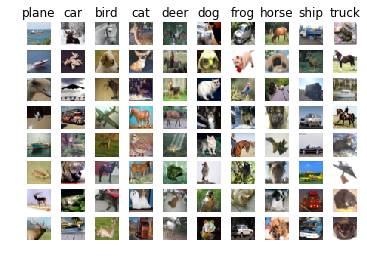

In [21]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ They do make sense. Lets remember that the classification is done on two features: color histogram and histogram of oriented gradients. The images that are misclassified are being misclassified under these two dimensions. 

For example, the template for planes knows two things: the gradients typically display objects with sharp, triangular edges and they typically exhibit a large amount of blue pixels. If we look at the misclassified images, we can see that they either have blue backgrounds (sky or ocean), or they have images that have sharp gradients, as you would see with a flying plane. 

The example can be extended to other classes as well. The images that are misclassified as cats tend to have brown objects, such as horses or deer, but not with green backgrounds. This is probably because there are a large number of brown cats in our training set, and unlike horses or deer, these tend to be indoors with other background colors. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [34]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 154)
(49000, 153)


In [65]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
results = {}

best_net = None
best_val = -1

num_classes = 10

hidden_size = [500] 
learning_rate = [0.4, 0.5, 0.6, 0.7] 
batch_size = [600]
regularization_strength = [1e-3, 1e-4]
# regularization_strength = [0.15, 0.2, 5e5, 10e5, 15e5]

for hsize in hidden_size:
    for lrate in learning_rate:
        for bsize in batch_size:
            for strength in regularization_strength:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)
                
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=500, batch_size=bsize,
                learning_rate=lrate, learning_rate_decay=0.95,
                reg=strength, verbose=True)

                # Predict on the validation set
                train_accuracy = (net.predict(X_train_feats) == y_train).mean()
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                print('Validation accuracy: ', val_acc)
                
                # Storing results in the dictionary
                results[(hsize, lrate, bsize, strength)] = (train_accuracy, val_acc)
                
                if val_acc > best_val:
                    best_val = val_acc
                    best_net = net
                    best_stats = stats

for key, value in results.items():
    print(key, value)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 500: loss 2.302586
iteration 100 / 500: loss 1.638240
iteration 200 / 500: loss 1.434881
iteration 300 / 500: loss 1.318567
iteration 400 / 500: loss 1.422102
Validation accuracy:  0.54
iteration 0 / 500: loss 2.302585
iteration 100 / 500: loss 1.601356
iteration 200 / 500: loss 1.427459
iteration 300 / 500: loss 1.342795
iteration 400 / 500: loss 1.275326
Validation accuracy:  0.544
iteration 0 / 500: loss 2.302586
iteration 100 / 500: loss 1.521489
iteration 200 / 500: loss 1.346990
iteration 300 / 500: loss 1.259497
iteration 400 / 500: loss 1.339567
Validation accuracy:  0.542
iteration 0 / 500: loss 2.302585
iteration 100 / 500: loss 1.506749
iteration 200 / 500: loss 1.344090
iteration 300 / 500: loss 1.268000
iteration 400 / 500: loss 1.282829
Validation accuracy:  0.536
iteration 0 / 500: loss 2.302586
iteration 100 / 500: loss 1.482887
iteration 200 / 500: loss 1.420933
iteration 300 / 500: loss 1.286386
iteration 400 / 500: loss 1.261588
Validation accuracy:  0.

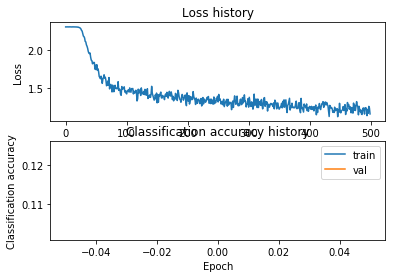

In [66]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [67]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.563
